In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import librosa
import librosa.display
import librosa.effects as le
import IPython.display as ipd
import matplotlib.pyplot as plt
import random

ModuleNotFoundError: No module named 'torchvision'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

RE_SR = 44100
BATCH_SIZE = 128

feature_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((200,200)),
    T.ToTensor()
])

cuda


NameError: name 'T' is not defined

In [153]:
def wav2melSpec(AUDIO_PATH):
    y, sr = librosa.load(AUDIO_PATH)
    audio = librosa.resample(y=y, orig_sr=sr, target_sr=RE_SR)
    return librosa.feature.mfcc(y=audio, sr=sr, n_fft=1024, n_mels=26, n_mfcc=26, hop_length=1024, win_length=1024)

def imgSpec(ms_feature):
    fig, ax = plt.subplots()
    ms_dB = librosa.power_to_db(ms_feature, ref=np.max)
    print(ms_feature.shape)
    img = librosa.display.specshow(ms_dB, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram');
    
def hear_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH) 
    # print("\t", end="")
    ipd.display(ipd.Audio(data=audio, rate=sr, autoplay=True))
    
def get_audio_info(path, show_melspec=False, label=None):
    spec = wav2melSpec(path)
    hear_audio(path)
    if show_melspec is not False:
        imgSpec(spec)

def wavframe(AUDIO_PATH, frame_duration=0.5):
    frame_length = int(sr * frame_duration)

    y, sr = librosa.load(AUDIO_PATH)
    y = librosa.resample(y=y, orig_sr=sr, target_sr=RE_SR)
    y_frames = le.frame(y, frame_length=frame_length)
    # y = librosa.effects.time_stretch(y, 1.0)
    # frames = [y[i:i+frame_length] for i in range(0, len(y), frame_length)]

    return y_frames, sr

In [154]:
class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None):
        self.path = path
        self.file_list = []
        self.feature_transform = feature_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] == "wav":
                    self.file_list.append(os.path.join(dirname, filename))

    def __getitem__(self, idx):
        try:
            spec = wav2melSpec(self.file_list[idx])
            spec = self.feature_transform(spec)
            return spec, self.file_list[idx]
        except:
            spec = wav2melSpec(self.file_list[0])
            spec = self.feature_transform(spec)
            return spec, self.file_list[idx]
    
    def __len__(self):
        return len(self.file_list)

In [155]:
class AudioClassifier(nn.Module):
    def __init__(self, num_feature_maps, layers):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, num_feature_maps, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps, num_feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//2),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//2, num_feature_maps//4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//4),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_feature_maps//4, num_feature_maps//8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//8),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//8, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
        )
        
        self.classifier = nn.ModuleList(
            [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        )
        
    def forward(self, x):
        a = self.conv_layer(x)
        for layer in self.classifier:
            a = layer(a)
        return a # as logits

In [156]:
test_ds = AudioDataset('C:\\AI\\SAFE_dataset\\_Demo\\frame\\6', feature_transform=feature_transform)
# print("File num: " + str(len(test_ds)), end="\n\n")

test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

num_feature_maps = 64
layers = [81, 32, 16, 8, 4, 2]
clf = AudioClassifier(num_feature_maps, layers)
clf.load_state_dict(torch.load("./model_test/model_epoch_2.pt"))
clf.to(device)
print(clf)


AudioClassifier(
  (conv_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(8, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): ModuleList(
    (0): Linear(in_features=81, out_features=32, bias=Tru

In [157]:
optim = torch.optim.Adam(params=clf.parameters(), betas=(0.5, 0.99))
loss_fn = nn.CrossEntropyLoss()

for batch, (X, txt) in enumerate(test_dataloader):
    X = X.to(device)
    y_logits = clf(X).to(device)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)
    # print(y_preds)

    accident = []

    count = 0
    for y_pred in y_preds:
        print(y_pred)
        if y_pred.item()== 1:
            print("정상상황")
            accident.append(0)
        elif y_pred.item()== 0:
            print("사고상황")
            accident.append(1)
        else:
            print("ERROR")

        # hear_audio(txt[count])
        # get_audio_info(txt[batch], label=y_preds[batch].item())
        print("\n----------------------------------------")
        count += 1



tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

----------------------------------------
tensor(1, device='cuda:0')
정상상황

-----

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


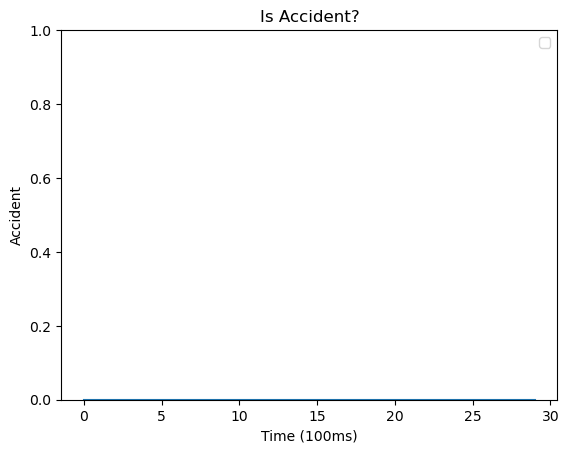

In [158]:
plt.plot(accident)
plt.ylim([0, 1])
plt.title('Is Accident?')
plt.xlabel('Time (100ms)')
plt.ylabel('Accident')
plt.legend()
plt.show()

hear_audio("C:\\AI\\SAFE_dataset\\_Demo\\orig\\9.wav")


In [159]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))
torch.cuda.empty_cache()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 110807 KiB | 537741 KiB |   2009 MiB |   1901 MiB |
|       from large pool | 110318 KiB | 535849 KiB |   1989 MiB |   1881 MiB |
|       from small pool |    488 KiB |   2882 KiB |     20 MiB |     19 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 110807 KiB | 537741 KiB |   2009 MiB |   1901 MiB |
|       from large pool | 110318 KiB | 535849 KiB |   1989 MiB |